<h2 style="font-family:camtasia;
          font-size:320%;
          font-weight: bold;
          color: #029db9;
          text-shadow: 2px 2px 2px rgba(0, 0, 0, 0.3);
          text-align:center;
          margin: 0 auto;
          padding:10px; ">
        Trash Type Classification using CNN
    </h2>

### Step 1 | Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from pathlib import Path
from tensorflow.keras import models, layers, optimizers

In [4]:
warnings.filterwarnings("ignore")

### Step 2 | Reading Files

In [5]:
data_path = '/content/drive/MyDrive/wastify'

In [6]:
print(os.listdir(data_path))

['organic', 'plastic', 'cardboard', 'paper', 'trash', 'metal', 'glass']


In [7]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
wastify,0
organic,458
plastic,482
cardboard,403
paper,594
trash,137
metal,410
glass,501


In [8]:
print(f'Total {count.sum()}')

Total File Count    2985
dtype: int64


In [ ]:
def plot_imgs(item_dir, top=10) :
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

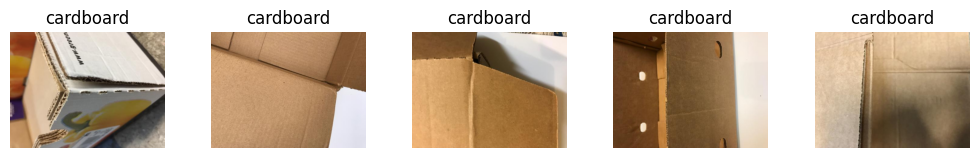

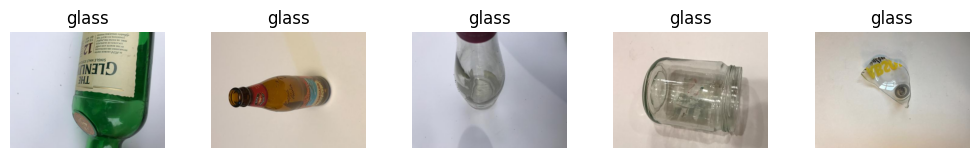

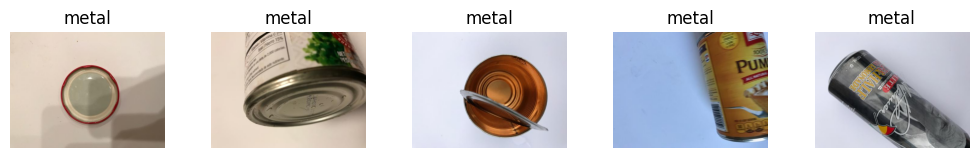

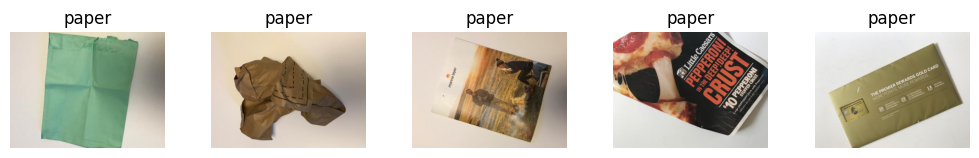

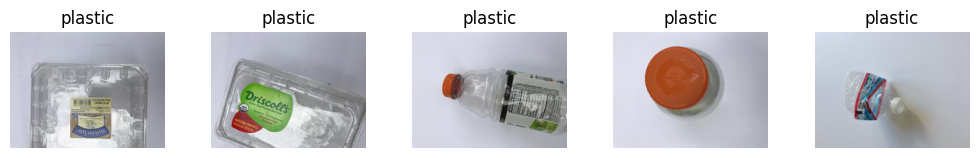

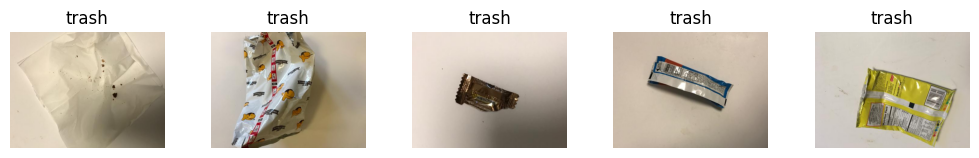

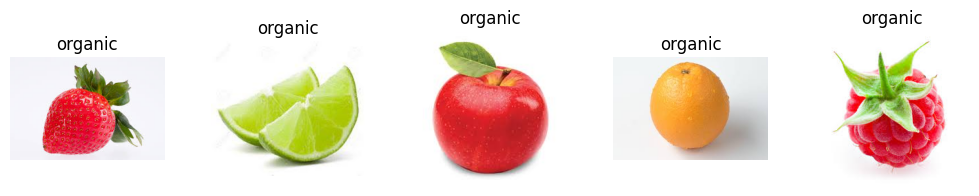

In [ ]:
plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')
plot_imgs(data_path+'/trash')
plot_imgs(data_path+'/organic')

### Step 3 | Generate Data

In [10]:
batch_size = 30
target_size = (180, 180)
validation_split = 0.15

In [11]:
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

### Step 4 | Split Train & Test Files

In [12]:
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2540 images belonging to 7 classes.


In [13]:
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 445 images belonging to 7 classes.


### Step 5 | Building Convolutional Neural Network Architecture

In [14]:
model = Sequential([
    ZeroPadding2D(padding=(1, 1), input_shape=(target_size[0], target_size[1], 3)),
    Conv2D(32, (3, 3), activation='relu'),
    layers.Dropout(0.3),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.3),
    MaxPool2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    layers.Dropout(0.4),
    MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Step 6 | Compile Model

In [15]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [16]:
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

In [17]:
MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

### Step 7 | Train Model

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=500,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

Epoch 1/500


In [ ]:
model.save('trash.h5')

### Step 8 | Model Evaluation

In [ ]:
best_score = max(history.history['val_categorical_accuracy'] )
print(f"Best Validation score is: {best_score}")

Best Validation score is: 0.6067415475845337


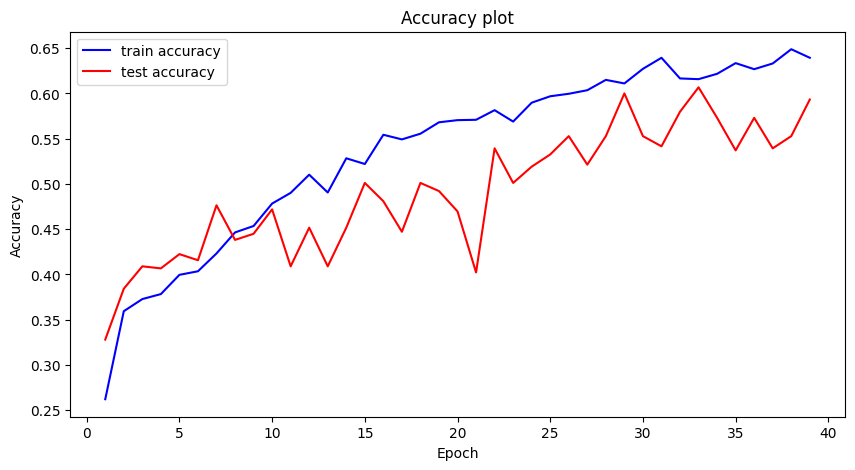

In [ ]:
accuracy = history.history['categorical_accuracy']

val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

### Step 9 |  Using Model

In [ ]:
classes = train_data.class_indices
classes

{'cardboard': 0,
 'glass': 1,
 'metal': 2,
 'organic': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

In [ ]:
img = utils.load_img(
    '/kaggle/input/trash-type-detection/trash_images/cardboard/cardboard_011.jpg',
    grayscale=False,
    color_mode='rgb',
    target_size=(180, 180),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/trash-type-detection/trash_images/cardboard/cardboard_011.jpg'

In [ ]:
img = utils.img_to_array(img)
img = img / 255.0

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

In [9]:
model = tf.keras.models.load_model('/content/trash.h5')

OSError: Unable to open file (truncated file: eof = 51380224, sblock->base_addr = 0, stored_eof = 87991408)

### Step 10 | Saving Model

In [ ]:
from google.colab import files
files.download('trash.h5')